# MGP-DCNN
### Python Implementation of MGP-DCNN 
### Paper : 


# 0] Prerequisites
- Install Pytorch
- Install keras
- Clone the repo https://github.com/TristanBertin/MGP-DCNN and ***do pip install .*** from the terminal

In [51]:
import torch
import gpytorch
import h5py
import numpy as np
import MGPDCNN         #our package using Keras and Pytorch
import matplotlib.pyplot as plt

### Import the data :

In [52]:
data_file = 'C:/Users/tmb2183/Desktop/myhmc/data/according_Clue_dataset_N_60_Sub_1_T_150_freq_1'

with h5py.File(data_file, 'r') as data:
    y_data = data['x_data'][:]

Set all the hyperparameters

In [53]:
nb_individuals = 5       #number of individuals 
nb_individuals_train = 3  #number of individuals for the training of the DCNN
nb_individuals_val = 1    #number of individuals for the validation of the DCNN
nb_individuals_test = 1   #number of individuals for the test of the DCNN
assert(nb_individuals_train + nb_individuals_val + nb_individuals_test == nb_individuals)

nb_time_steps = 105       #number of time steps
nb_train_time_steps = 70  #time limit for the training (limit between reconstruction and forecast)

nb_selected_points = 70   #number of points selected for the taining of the MGP (< nb_train_time_steps)
nb_input_tasks = 5        #number of tasks selected for the input and output of the MGP = input DCNN
nb_output_tasks = 5       #number of tasks selected for the output of the DCNN

# 1 ] MGP

#### This is the first step of the model. A Multitask Gaussian Process is trained on the input data. 

## 1.1 Prepare the data for the training

In [54]:
y_data = MGPDCNN.data_processing.align_data_on_peak(y_data, length=nb_time_steps, column=0)
print(y_data.shape)

(60, 105, 5)


#### Restrict the data in order to get the right size

In [55]:
y_data = y_data[:nb_individuals, :nb_time_steps]
print(y_data.shape)

(5, 105, 5)


#### (OPTIONAL BUT HIGHLY RECOMMANDED) Scale the Data for the training of the MGP

In [56]:
from sklearn.preprocessing import MinMaxScaler
sklearn_scaler = MinMaxScaler()

You have to specify which blocks will be used for the MGP, in other words the structure of the covariance matrix will be block-diagonal wih respect to those indices. For exampl, if you want independant GPs, use block_indices = [[0],[1],[2],..]
Those indices correspond to the the last axis (the axis that contains nb_input_tasks columns)

In [57]:
block_indices = [[0,1],[2,3,4]]  #Indices of the tasks for each MGP, each sublist is a block in the total covariance matrix
                                 # ---> cardinal should be equal to nb_input  
assert(np.concatenate(block_indices).shape[0] == nb_input_tasks)
nb_blocks = len(block_indices)

#### BUILD THE DATASET :
If you don't want to scale the data, don't specify any argument for 'scaler'. In the other case, the scaler will be parametrized on the training data only and will be returned in order to inverse the scaling after. 


In [58]:
train_x, train_y, test_x, test_y, parametrized_scaler = MGPDCNN.prepare_data_before_GP(y_data,
                                                                  block_indices = block_indices,
                                                                  nb_time_steps = nb_time_steps,
                                                                  nb_train_time_steps = nb_train_time_steps,
                                                                  nb_train_individuals = nb_individuals_train,
                                                                  scaler=sklearn_scaler)

#### The arrays are now torch Tensors (required for Gpytorch)

In [59]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

torch.Size([70]) torch.Size([5, 70, 5])
torch.Size([105]) torch.Size([5, 105, 5])


**Note** that the test set is just an extended time period of the train set. We must keep in mind that the test array will feed the DCNN after. We use here 'train' and 'test' for the delimitation in time between the reconstruction and the prediction. It has nothing to do with the individuals used for the training and the test... (Remember that the MGP is trained on the individual level : same behavior for every individual)

**Note also** that the x values (time) are scaled ! Indeed they are in the range [0,1]

## 1.2  Train the MGP
#### You can trained news MGP and save the ouput OR load the data from a previous dataset depending on the value of  'new_h5' 

In [87]:
new_h5 = True  # generate a new dataset = training of the MGP

Specify the parameters for the training of the MGP, 'n_iter' represnets the maximal number of iterations for the Adam Optimizer that backpropagates the error

In [88]:
n_iter = 500               # max of iterations for the training of the MGP
learning_rate_gp = 0.02    # learning rate for the trainig of the MGP

This is the time kernel, see gpytorch.kernels to see all the possible kernels, here we aslo set a prior for the period_length parameter : see gpytorch.priors for more info 

In [89]:
time_kernel = gpytorch.kernels.PeriodicKernel(
    period_length_prior = gpytorch.priors.NormalPrior(0.31,0.1))

#### Now let's train the multiple MGPs (one for each individual)

### Precisions:
#### Inputs
- **nb_selected_points** : number of points that are used for the training of the MGP. They are selected randomly BUT (see next line)
- **nb_peaks_selected** :  you can specify how many samples from the peaks you want to have in you subselection of points, the peaks are selected from the first task of the first block. if this value is different from 0, the time steps that correspond to the peaks are necessarly choosen. If nb_peaks_selected = 0, the time selection is totaly random.
- **save_h5** :indiciates whether or not you want to save the ouputs
- **activate_plot** : plot the covariances matrix per bloc, the loss per block and the regressions curves for each individual (each MGP)
- **smart_end** : stops the training when the loss starts increasing too much --> avoid classic behaviors of MGP that start to have a very noisy loss when they start to overfit
- **nb_peaks_selected** :

#### Output
 - **h5_dataset_path** is the path of the h5_file that contains all the output means and coavariances matrix per bloc of each individual.

###########      INDIVIDUAL 0    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 87.433
Iter 101/500 - Loss: 18.934
Iter 201/500 - Loss: -49.532
Iter 301/500 - Loss: -97.112
### BLOCK 1 ###
Iter 1/500 - Loss: 85.067
Iter 101/500 - Loss: 20.667
Iter 201/500 - Loss: -45.783


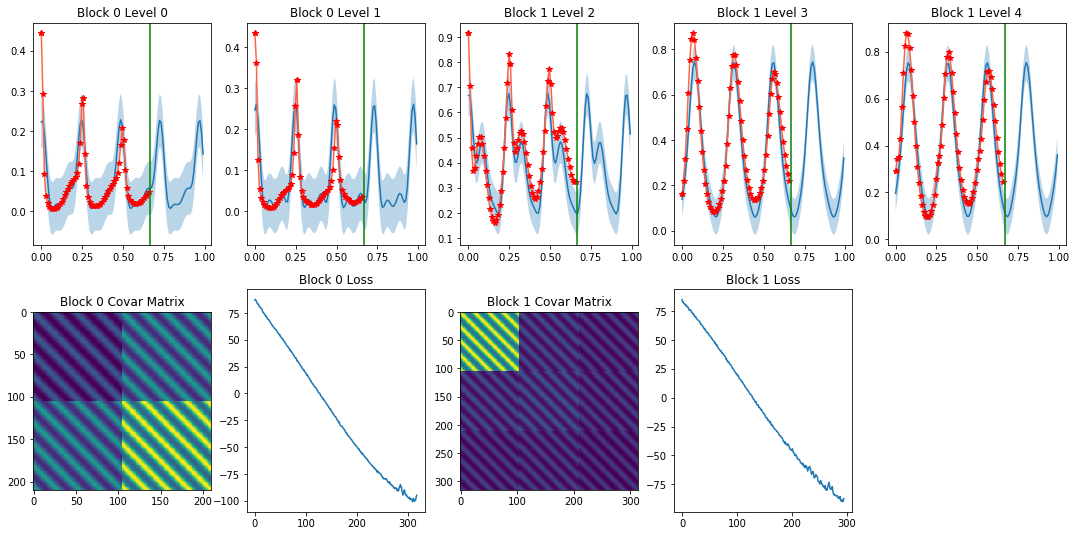

###########      INDIVIDUAL 1    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 86.091
Iter 101/500 - Loss: 24.641
Iter 201/500 - Loss: -19.650
### BLOCK 1 ###
Iter 1/500 - Loss: 84.632
Iter 101/500 - Loss: 22.439
Iter 201/500 - Loss: -39.887


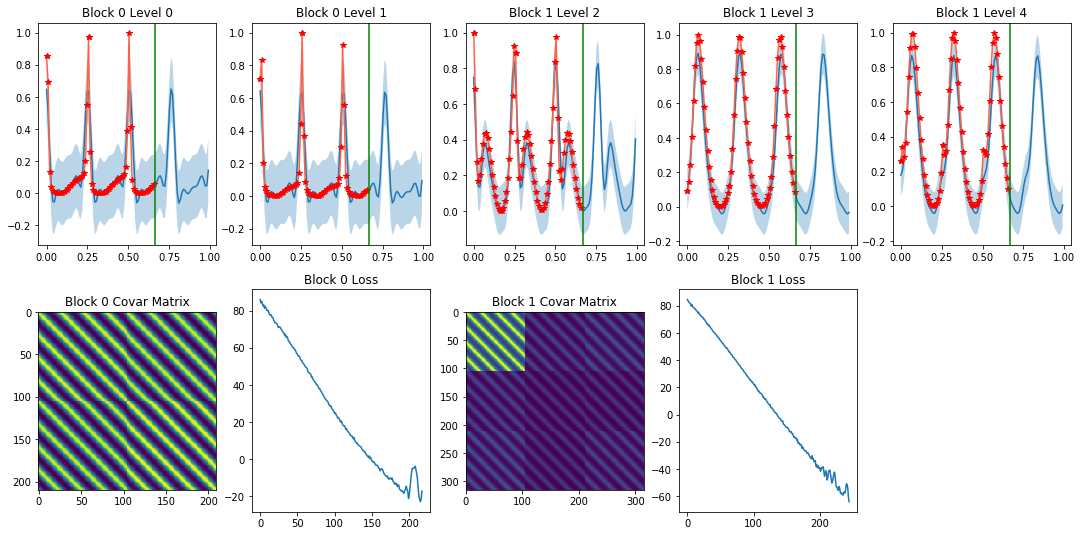

###########      INDIVIDUAL 2    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 83.645
Iter 101/500 - Loss: 16.006
Iter 201/500 - Loss: -59.571
Iter 301/500 - Loss: -131.178
### BLOCK 1 ###
Iter 1/500 - Loss: 82.573
Iter 101/500 - Loss: 18.172
Iter 201/500 - Loss: -54.690
Iter 301/500 - Loss: -121.706


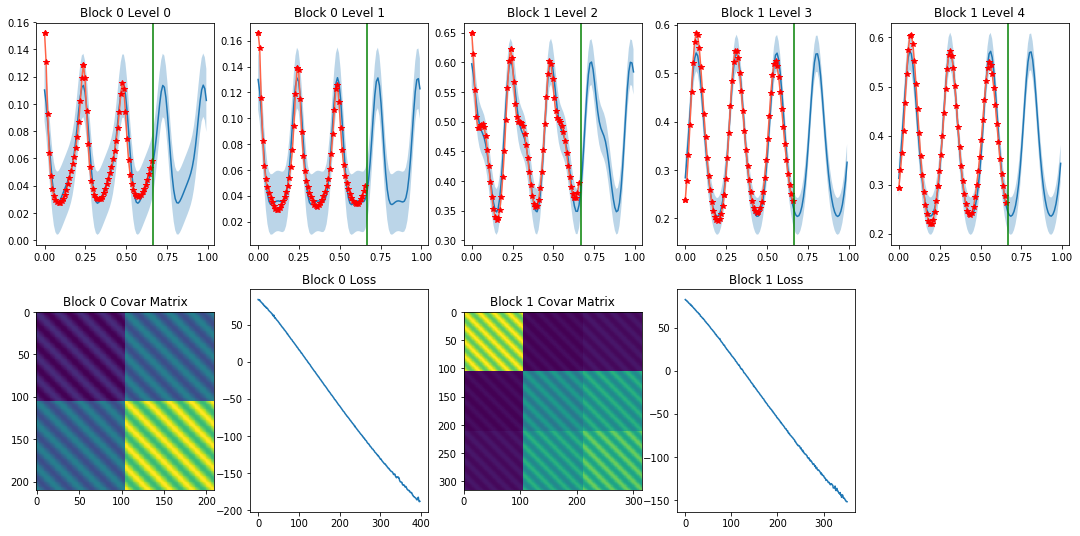

###########      INDIVIDUAL 3    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 82.239
Iter 101/500 - Loss: 18.029
Iter 201/500 - Loss: -57.746
Iter 301/500 - Loss: -133.073
Iter 401/500 - Loss: -200.435
### BLOCK 1 ###
Iter 1/500 - Loss: 81.155
Iter 101/500 - Loss: 17.624
Iter 201/500 - Loss: -55.416
Iter 301/500 - Loss: -123.955


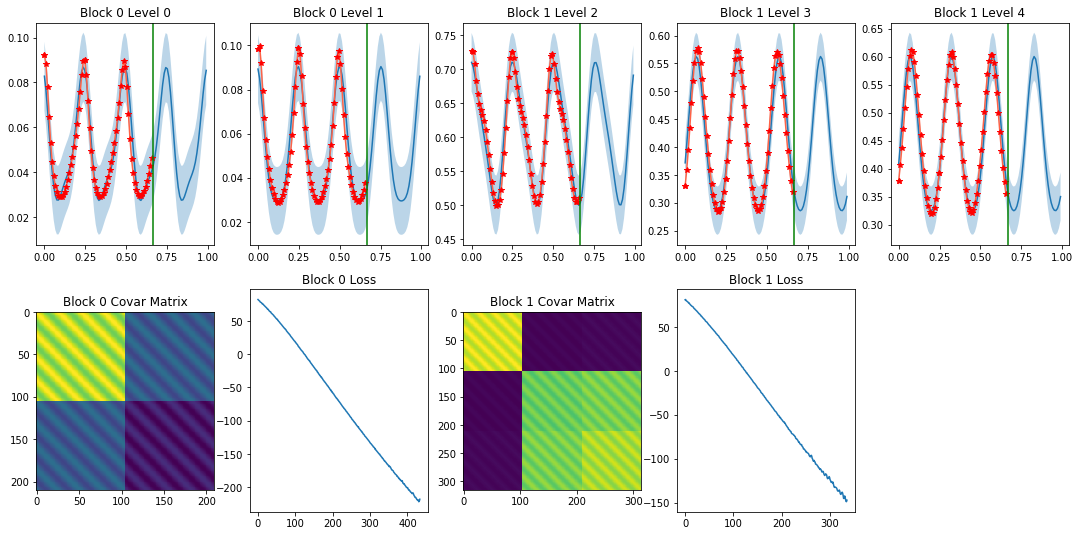

###########      INDIVIDUAL 4    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 82.319
Iter 101/500 - Loss: 16.886
Iter 201/500 - Loss: -55.678
Iter 301/500 - Loss: -111.129
Iter 401/500 - Loss: -126.457
### BLOCK 1 ###
Iter 1/500 - Loss: 83.762
Iter 101/500 - Loss: 21.556
Iter 201/500 - Loss: -44.054


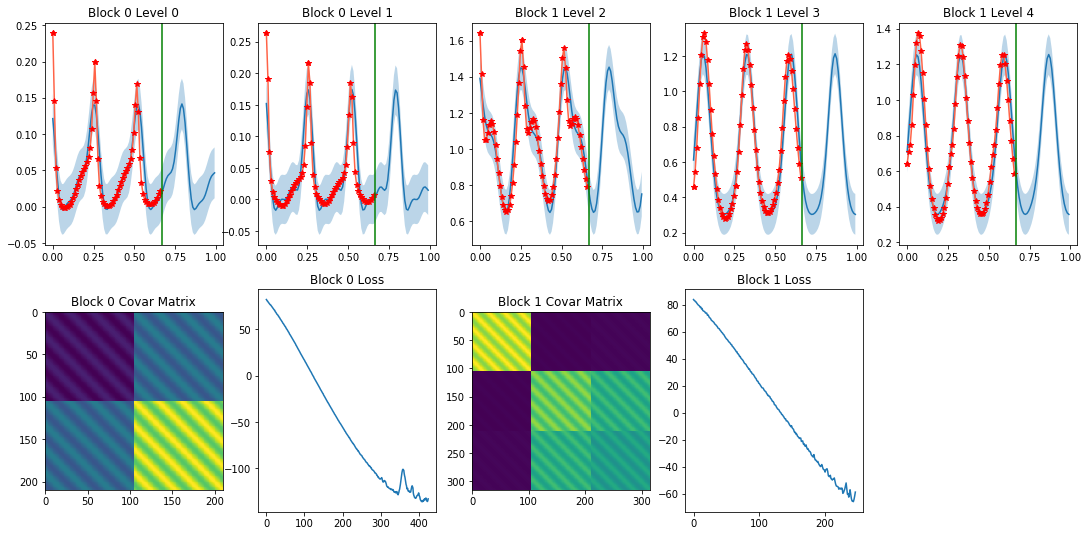

In [90]:
if new_h5 == True:
    h5_dataset_path = MGPDCNN.train_Block_MGP_multiple_individuals(train_x, train_y, block_indices, test_x,
                                                       kernel=time_kernel, learning_rate=learning_rate_gp, n_iter=n_iter,
                                                       nb_selected_points = nb_selected_points, nb_peaks_selected = 0,
                                                       activate_plot=True, smart_end = True)

## 1. 3 Load the data from a trained MGP

#### You can here specify the path of the h5 file you want to load ;

In [91]:
if new_h5 == False:
    h5_dataset_path = 'output_models/OUTPUT_MGP_Nb_individuals_%d_Time_%d_Selected_points_%d_Nb_blocks_%d_Nb_peaks_%d'\
                      %(5, nb_time_steps, nb_selected_points, nb_blocks, 0)
    print(h5_dataset_path)

# 2 ] DCNN

## 2.1 Build the dataset from the ouput of the MGPs

#### We scale the data with the same scaler as the one used for the training of the MGP.

In [65]:
if parametrized_scaler != None:
    y_data = parametrized_scaler.transform(y_data.reshape(-1,5)).reshape(-1,105,5)

### And we build our dataset...
#### Inputs :
- **output_gp_path** : the path of the file we just created (the mean anc covariance matrices of the Block MGP)
- **y_true** : the full y_data array
- **nb_samples_per_id** : if = 1 : we just take the mean as input for the DCNN,      if >1 : we sample 'nb_samples_per_id' postriors from the each individual distribution... (default=1)
- **plot_some_posteriors** : to see the shapes of some posteriors...

In [66]:
nb_samples_per_id = 50         # number of posteriors samples we want to drawn from each individual distribution

C:\Users\tmb2183\Desktop\MGP-DCNN\MGPDCNN\data_processing.py:120: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.random.multivariate_normal(gp_out_mean, covar_matrix, num_samples)


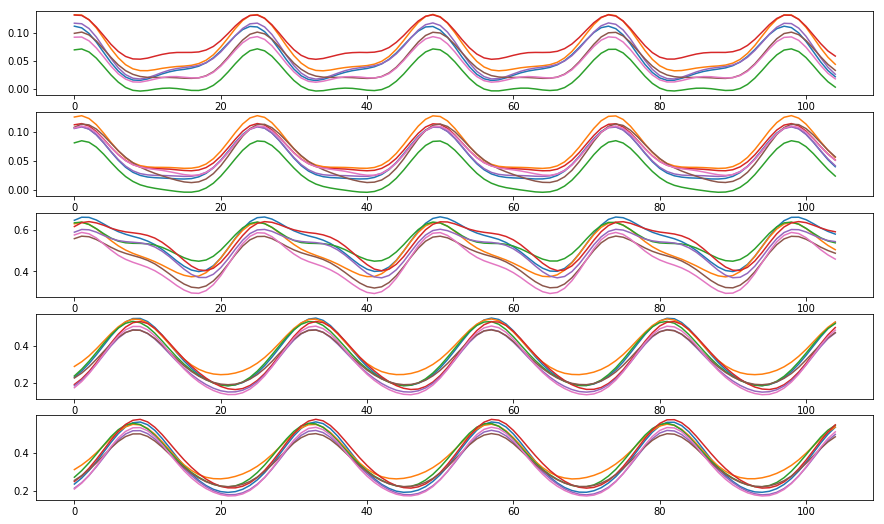

In [67]:
x_train, y_train, x_val, y_val, x_test, y_test = \
    MGPDCNN.import_and_split_data_train_val_test( output_gp_path = h5_dataset_path,
                                                          y_true = y_data,
                                                          block_indices= block_indices,
                                                          nb_timesteps = nb_time_steps,
                                                          nb_tasks = nb_input_tasks,
                                                          nb_individuals = nb_individuals,
                                                          nb_individuals_train = nb_individuals_train,
                                                          nb_individuals_val = nb_individuals_val,
                                                          nb_individuals_test = nb_individuals_test,
                                                          nb_samples_per_id=nb_samples_per_id,
                                                          plot_some_posteriors = True)

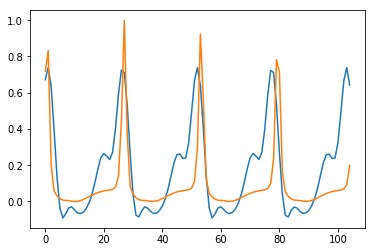

In [72]:
plt.plot(x_train[56,:,1])
plt.plot(y_train[56,:,1])
plt.show()

## 2.2 Build the Neural Network 

In [84]:
network = MGPDCNN.Time_Neural_Network('CNN', nb_selected_points=nb_selected_points,
                              nb_peaks_selected=0,
                              batch_size=50, nb_epochs=50,
                              x_train=x_train, y_train=y_train,
                              x_test=x_test, y_test=y_test,
                              x_val=x_val, y_val=y_val)

## 2.3 Train and test the network
### Train

In [85]:
network.build_TNN(learning_rate=0.1, nb_hidden_layers=2, nb_filters=4,regularizer_coef=1e-7, kernel_size=6, dilation_factor=1, display_summary=False)

In [86]:
val_loss = network.train_validate_TNN(regression_plot=True)

Time 3.201042413711548 Learning_rate 0.1 || nb_layers 2 || nb_filters 4 || kernel_size 6 || regularizer_coef 1e-07 || VAL LOSS 0.006718585733324289


## 2.4 Bayesian Optimization
#### Find the best hyperparameters for the neural network using Bayesian Optimization and Expected Improvement

In [74]:
from skopt.space import Real, Integer

dim_learning_rate = Real(low=2e-3, high=1.2e-2, prior='log-uniform', name='learning_rate')
dim_nb_hidden_layers = Integer(low=3, high=6, name='nb_layers')
dim_nb_filters = Integer(low=5, high=12, name='nb_filters')
dim_regularizer_coef = Real(low=1e-7, high=1e-3, prior='log-uniform', name='regularizer_coef')
dim_kernel_size = Integer(low=2, high=4, name='kernel_size')
dim_dilation_factor = Integer(low=2, high=4, name='kernel_size')
parameters_range = [dim_learning_rate,dim_nb_hidden_layers,dim_nb_filters,dim_regularizer_coef, dim_kernel_size, dim_dilation_factor]
default_parameters = [2e-3, 4, 7, 4e-7, 2, 4]

--------------------- CNN ----------------------
Time 10.92813754081726 Learning_rate 0.002 || nb_layers 4 || nb_filters 7 || kernel_size 2 || regularizer_coef 4e-07 || VAL LOSS 0.0052786201052367684
--------------------- CNN ----------------------
Time 13.898173332214355 Learning_rate 0.005871670005951735 || nb_layers 5 || nb_filters 10 || kernel_size 2 || regularizer_coef 7.545482030297609e-07 || VAL LOSS 0.0036103850789368152
--------------------- CNN ----------------------
Time 18.277225017547607 Learning_rate 0.011875197390001929 || nb_layers 6 || nb_filters 11 || kernel_size 4 || regularizer_coef 0.00023569908228387854 || VAL LOSS 0.011098865494132042
--------------------- CNN ----------------------
Time 6.691542148590088 Learning_rate 0.009153208515507006 || nb_layers 3 || nb_filters 12 || kernel_size 2 || regularizer_coef 0.0005037601476877294 || VAL LOSS 0.007036036066710949


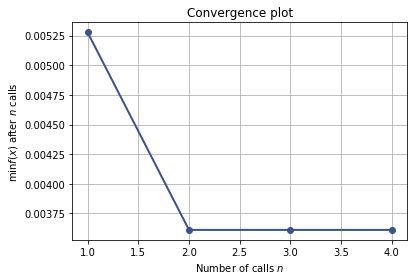

In [75]:
search_result = network.optimization_process(parameters_range,
                             default_parameters=default_parameters,
                             nb_calls = 4,
                             nb_random_starts = 1,
                             plot_conv=True)